In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import gdown
import re
import textwrap
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download("stopwords")
nltk.download("punkt")

from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip install rouge

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader, Dataset
import random
import os
from torch.optim.lr_scheduler import StepLR

In [4]:
print("📦 Library Versions")
print("----------------------")
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
# print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)
# print("scikit-learn:", sklearn.__version__)
print("nltk:", nltk.__version__)
print("PyTorch:", torch.__version__)
# print("TensorFlow:", tf.__version__)
print("rouge:", Rouge.__version__ if hasattr(Rouge, '__version__') else Rouge)
print("tqdm:", tqdm)

📦 Library Versions
----------------------
Pandas: 2.2.3
NumPy: 1.26.4
Seaborn: 0.12.2
nltk: 3.2.4
PyTorch: 2.5.1+cu121
rouge: <class 'rouge.rouge.Rouge'>
tqdm: <class 'tqdm.std.tqdm'>


In [5]:
# https://drive.google.com/drive/folders/1FlqoweTW1g-KY8jWf7x8iavKFB3Jqojk?usp=sharing
# URL of the shared folder
folder_url = "https://drive.google.com/drive/folders/1FlqoweTW1g-KY8jWf7x8iavKFB3Jqojk?usp=sharing"

# Output directory where the folder will be saved
output_dir = "Lab10b"

# Download the folder
gdown.download_folder(folder_url, output=output_dir, quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 1f1adAObXfjZmX6VlXIikoDZNeukQKsTW test.csv
Processing file 1Wy_M9JCJ-eBvA880GpQpJll54TFo6H3Y train.csv
Processing file 1H0qexwZ4657VsZhvm2ysYwMb1SEpPJNa validation.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1f1adAObXfjZmX6VlXIikoDZNeukQKsTW
To: /kaggle/working/Lab10b/test.csv
100%|██████████| 49.9M/49.9M [00:00<00:00, 77.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Wy_M9JCJ-eBvA880GpQpJll54TFo6H3Y
From (redirected): https://drive.google.com/uc?id=1Wy_M9JCJ-eBvA880GpQpJll54TFo6H3Y&confirm=t&uuid=e11b4ed3-7d90-4b44-a131-0e520df8b9cd
To: /kaggle/working/Lab10b/train.csv
100%|██████████| 1.26G/1.26G [00:11<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H0qexwZ4657VsZhvm2ysYwMb1SEpPJNa
To: /kaggle/working/Lab10b/validation.csv
100%|██████████| 57.7M/57.7M [00:00<00:00, 117MB/s]
Download completed


['Lab10b/test.csv', 'Lab10b/train.csv', 'Lab10b/validation.csv']

In [6]:
def load_dataset(dataset_path):
    df = pd.read_csv(dataset_path)
    # Drop id column
    df.drop(columns=['id'],inplace=True)
    # Drop null values (if any)
    df.dropna(inplace=True)
    print("Number of records:",len(df))
    return df

def wrap(x):
    return textwrap.fill(x,replace_whitespace=False,fix_sentence_endings=True)



In [7]:
df_train = load_dataset(r'Lab10b/train.csv')
df_train.columns = ['text', 'summary']
df_train.head(2)

Number of records: 287113


,text,summary
0,"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepatitis A include fever, tiredness, loss of appetite, nausea and abdominal discomfort. Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located .","Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed ."
1,"(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization to help plan a murder plot and get guns. A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as ""The Milk Man,"" of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch. In one instance, the complaint alleges, Mata arranged to pay two assassins to kill rival drug dealers. The killers would pose as cops, pulling over their targets before shooting them, according to the complaint. ""Ultimately, the (organization) decided not to move forward with the murder plot, but Mata still received a payment for setting up the meetings,"" federal prosecutors said in a statement. The complaint also alleges that Mata used his police badge to purchase weapons for drug traffickers. Mata, according to the complaint, then used contacts at the airport to transport the weapons in his carry-on luggage on trips from Miami to the Dominican Republic. Court documents released by investigators do not specify the name of the drug trafficking organization with which Mata allegedly conspired but says the organization has been importing narcotics from places such as Ecuador and the Dominican Republic by hiding them ""inside shipping containers containing pallets of produce, including bananas."" The organization ""has been distributing narcotics in New Jersey and elsewhere,"" the complaint says. Authorities arrested Mata on Tuesday in Miami Gardens, Florida. It was not immediately clear whether Mata has an attorney, and police officials could not be immediately reached for comment. Mata has worked for the Miami-Dade Police Department since 1992, including directing investigations in Miami Gardens and working as a lieutenant in the K-9 unit at Miami International Airport, according to the complaint. Since March 2010, he had been working in the internal affairs division. Mata faces charges of aiding and abetting a conspiracy to distribute cocaine, conspiring to distribute cocaine and engaging in monetary transactions in property derived from specified unlawful activity. He is scheduled to appear in federal court in Florida on Wednesday. If convicted, Mata could face life in prison. CNN's Suzanne Presto contributed to th

In [8]:
df_val = load_dataset(r'Lab10b/validation.csv')
df_val.columns = ['text', 'summary']
df_val.head(2)

Number of records: 13368


,text,summary
0,"Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films such as the 1956 noir While the City Sleeps died on March 15 at her home in Beverly Hills, California. Forrest, whose birth name was Katherine Feeney, was 86 and had long battled cancer. Her publicist, Judith Goffin, announced the news Thursday. Scroll down for video . Actress: Sally Forrest was in the 1951 Ida Lupino-directed film 'Hard, Fast and Beautiful' (left) and the 1956 Fritz Lang movie 'While the City Sleeps' A San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films including the critical and commercial success Not Wanted, Never Fear and Hard, Fast and Beautiful. Some of Forrest's other film credits included Bannerline, Son of Sinbad, and Excuse My Dust, according to her iMDB page. The page also indicates Forrest was in multiple Climax! and Rawhide television episodes. Forrest appeared as herself in an episode of The Ed Sullivan Show and three episodes of The Dinah Shore Chevy Show, her iMDB page says. She also starred in a Broadway production of The Seven Year Itch. City News Service reported that other stage credits included As You Like It, No, No, Nanette and Damn Yankees. Forrest married writer-producer Milo Frank in 1951. He died in 2004. She is survived by her niece, Sharon Durham, and nephews, Michael and Mark Feeney. Career: A San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films .","Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films died on March 15 .\nForrest, whose birth name was Katherine Feeney, had long battled cancer .\nA San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films ."
1,"A middle-school teacher in China has inked hundreds of sketches that are beyond be-leaf. Politics teacher Wang Lian, 35, has created 1000 stunning ink drawings covering subjects as varied as cartoon characters and landscapes to animals, birds according to the People's Daily Online. The intricate scribbles on leaves feature Wang's favourite sites across the city of Nanjing, which include the Presidential Palace, Yangtze River Bridge, the ancient Jiming Temple and the Qinhuai River. Natural canvas: Artist and teacher Wang Lian has done hundreds of drawings, like this temple, on leaves she collects in the park and on the streets . Delicate: She uses an ink pen to gently draw the local scenes and buildings on the dried out leaves . 'Although teaching politics is my job, drawing is my passion and hobby,' said Wang. 'I first tried drawing on leaves about 10 years ago and fell in love with it as an art form immediately. 'It's like drawing on very old parchment paper, you have to be really careful that you don't damage the leaf because it is very fragile and this helps focus your attention and abilities.' Wang started giving the drawings away on Christmas Eve in 2012 when her junior high school son came home saying he wanted to prepare some gifts for his classmates. Being an avid painter, Wang decided to give her son's friends unique presents of gingko leaf paintings. Wang loves gingko leaves and will often pick them up along Gingko Avenue, near to her school, in Nanjing in east China's Jiangsu province. Every autumn she collects about 2,000 leaves from the ground to ensure she has enough to cover spoils too. Intricate: Teacher Wang has drawn hundreds of local scenes on leaves she has collected from the park . Hobby: The artist collects leaves every autumn and dries them out so she can sketch these impressive building scenes . 'The colour and shape of gingko leaves are particularly beautiful,' she said. 'I need to collect around 2000 leaves because this will include losses'. She takes them home where she then presses them between the pages of boo

In [9]:
df_test = load_dataset(r'Lab10b/test.csv')
df_test.columns = ['text', 'summary']
df_test.head(2)

Number of records: 11490


,text,summary
0,"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee. 'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting for space in the overhead lockers, crashing elbows and seat back kicking? Tests conducted by the FAA use planes with a 31 inch pitch, a standard which on some airlines has decreased . Many economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches . Cynthia Corbertt, a human factors researcher with the Federal Aviation Administration, that it conducts tests on how quickly passengers can leave a plane. But these tests are conducted using planes with 31 inches between each row of seats, a standard which on some airlines has decreased, reported the Detroit News. The distance between two seats from one point on a seat to the same point on the seat behind it is known as the pitch. While most airlines stick to a pitch of 31 inches or above, some fall below this. While United Airlines has 30 inches of space, Gulf Air economy seats have between 29 and 32 inches, Air Asia offers 29 inches and Spirit Airlines offers just 28 inches. British Airways has a seat pitch of 31 inches, while easyJet has 29 inches, Thomson's short haul seat pitch is 28 inches, and Virgin Atlantic's is 30-31.",Experts question if packed out planes are putting passengers at risk .\nU.S consumer advisory group says minimum space must be stipulated .\nSafety tests conducted on planes with more leg room than airlines offer .
1,"A drunk teenage boy had to be rescued by security after jumping into a lions' enclosure at a zoo in western India. Rahul Kumar, 17, clambered over the enclosure fence at the Kamla Nehru Zoological Park in Ahmedabad, and began running towards the animals, shouting he would 'kill them'. Mr Kumar explained afterwards that he was drunk and 'thought I'd stand a good chance' against the predators. Next level drunk: Intoxicated Rahul Kumar, 17, climbed into the lions' enclosure at a zoo in Ahmedabad and began running towards the animals shouting 'Today I kill a lion!' Mr Kumar had been sitting near the enclosure when he suddenly made a dash for the lions, surprising zoo security. The intoxicated teenager ran towards the lions, shouting: 'Today I kill a lion or a lion kills me!' A zoo spokesman said: 'Guards had earlier spotted him close to the enclosure but had no idea he was planing to enter it. 'Fortunately, there are eight moats to cross before getting to where the lions usually are and he fell into the second one, allowing guards to catch up with him and take him out. 'We then handed him over to the police.' Brave fool: Fortunately, Mr Kumar fell into a moat as he ran towards the lions and could be rescued by zoo security staff before reaching the animals (stock image) Kumar later explained: 'I don't really know why I did it. 'I was drunk and thought I'd stand a good chance.' A police spokesman said: 'He has been cautioned and will be sent for psychiatric evaluation. 'Fortunately for him, the lions were asleep and the zoo guards acted quickly enough to prevent a tragedy similar to that in Delhi.' Last year a 20-y

In [10]:
# Contraction mapping
contractions = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", 
    "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", 
    "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", 
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", 
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", 
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", 
    "oughtn't": "ought not", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
    "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have", 
    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
    "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
    "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
    "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
    "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", 
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", 
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
    "you've": "you have"
}

# Compile regex for URLs and punctuation
url_pattern = re.compile(r'https?://\S+|www\.\S+')
punct_pattern = re.compile(r"[^\w\s]")

# Cleaner version of the text cleaning function
# def text_cleaning(text):
#     if not isinstance(text, str):
#         return ""
    
#     text = text.lower()
    
#     # Expand contractions
#     # for contraction, expanded in contractions.items():
#     #     text = re.sub(r"\b" + re.escape(contraction) + r"\b", expanded, text)
    
#     # Remove URLs
#     text = url_pattern.sub('', text)

#     # Remove punctuation
#     text = punct_pattern.sub('', text)

#     # Remove extra whitespace
#     text = re.sub(r"\s+", ' ', text).strip()

#     return text

def text_cleaning(text):
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = url_pattern.sub('', text)

    # Remove emails (optional)
    text = re.sub(r'\S+@\S+', '', text)

    # Replace INC/CM/CHG numbers with placeholders (optional but from your original function)
    text = re.sub(r'\binc\d+\b', 'inc_num', text)
    text = re.sub(r'\b(cm|chg)\d+\b', 'cm_num', text)

    # Remove special characters/punctuation
    text = punct_pattern.sub(' ', text)

    # Remove hanging single characters (like " a b c ")
    text = re.sub(r'\b\w\b', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [11]:
df_train['text_clean'] = df_train['text'].progress_apply(text_cleaning)
df_val['text_clean'] = df_val['text'].progress_apply(text_cleaning)
df_test['text_clean'] = df_test['text'].progress_apply(text_cleaning)

df_train['summary_clean'] = df_train['summary'].progress_apply(text_cleaning)
df_val['summary_clean'] = df_val['summary'].progress_apply(text_cleaning)
df_test['summary_clean'] = df_test['summary'].progress_apply(text_cleaning)

# Add _START_ and _END_ to each row in summary_clean
df_train['summary_clean'] = df_train['summary_clean'].progress_apply(lambda x: "_START_ " + str(x).strip() + " _END_")
df_val['summary_clean']   = df_val['summary_clean'].progress_apply(lambda x: "_START_ " + str(x).strip() + " _END_")
df_test['summary_clean']  = df_test['summary_clean'].progress_apply(lambda x: "_START_ " + str(x).strip() + " _END_")

100%|██████████| 11490/11490 [00:00<00:00, 715362.68it/s]


In [12]:
# df_train.to_csv('train_clean.csv', index=False)
# df_val.to_csv('val_clean.csv', index=False)
# df_test.to_csv('test_clean.csv', index=False)

In [13]:
df_train.head(2)

,text,summary,text_clean,summary_clean
0,"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepatitis A include fever, tiredness, loss of appetite, nausea and abdominal discomfort. Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located .","Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .",by associated press published 14 11 est 25 october 2013 updated 15 36 est 25 october 2013 the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda pictured of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis state immunization program manager molly howell says the risk is low but officials feel it important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis the diocese says he contracted the infection through contaminated food while attending conference for newly ordained bishops in italy last month symptoms of hepatitis include fever tiredness loss of appetite nausea and abdominal discomfort fargo catholic diocese in north dakota pictured is where the bishop is located,_START_ bishop john folda of north dakota is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in fargo grand forks and jamestown could have been exposed _END_
1,"(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization to help plan a murder plot and get guns. A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as ""The Milk Man,"" of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch. In one instance, the complaint alleges, Mata arranged to pay two assassins to kill rival drug dealers. The killers would pose as cops, pulling over their targets before shooting them, according to the complaint. ""Ultimately, the (organization) decided not to move forward with the murder plot, but Mata still received a payment for setting up the meetings,"" federal prosecutors said in a statement. The complaint also alleges that Mata used his police badge to purchase weapons for drug traffickers. Mata, according to the complaint, then

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


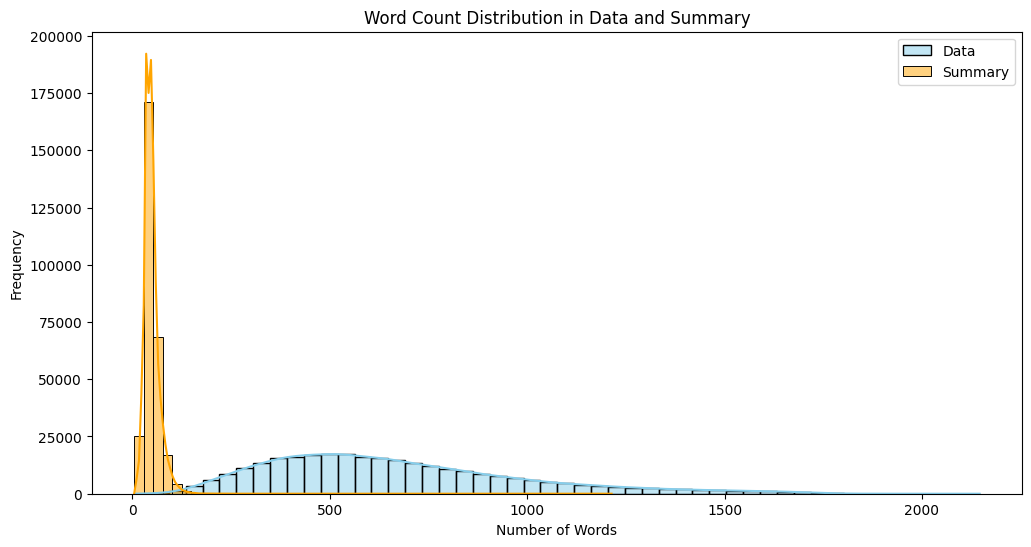

In [14]:
# Step 1: Count number of words in each row
df_train['data_word_count'] = df_train['text_clean'].apply(lambda x: len(str(x).split()))
df_train['summary_word_count'] = df_train['summary_clean'].apply(lambda x: len(str(x).split()))

# Step 2: Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_train['data_word_count'], bins=50, kde=True, color='skyblue', label='Data')
sns.histplot(df_train['summary_word_count'], bins=50, kde=True, color='orange', label='Summary')
plt.title("Word Count Distribution in Data and Summary")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


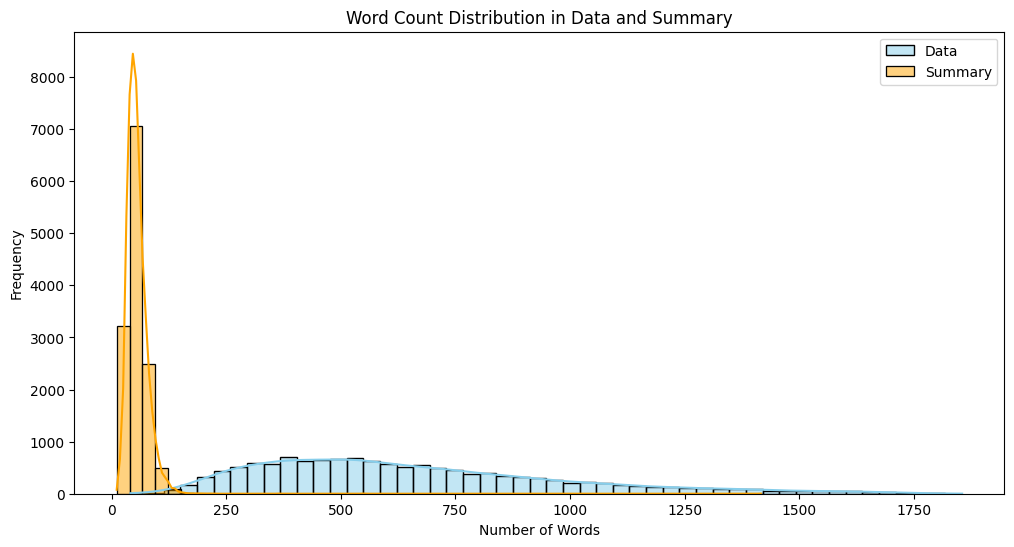

In [15]:
# Step 1: Count number of words in each row
df_val['data_word_count'] = df_val['text_clean'].apply(lambda x: len(str(x).split()))
df_val['summary_word_count'] = df_val['summary_clean'].apply(lambda x: len(str(x).split()))

# Step 2: Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_val['data_word_count'], bins=50, kde=True, color='skyblue', label='Data')
sns.histplot(df_val['summary_word_count'], bins=50, kde=True, color='orange', label='Summary')
plt.title("Word Count Distribution in Data and Summary")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


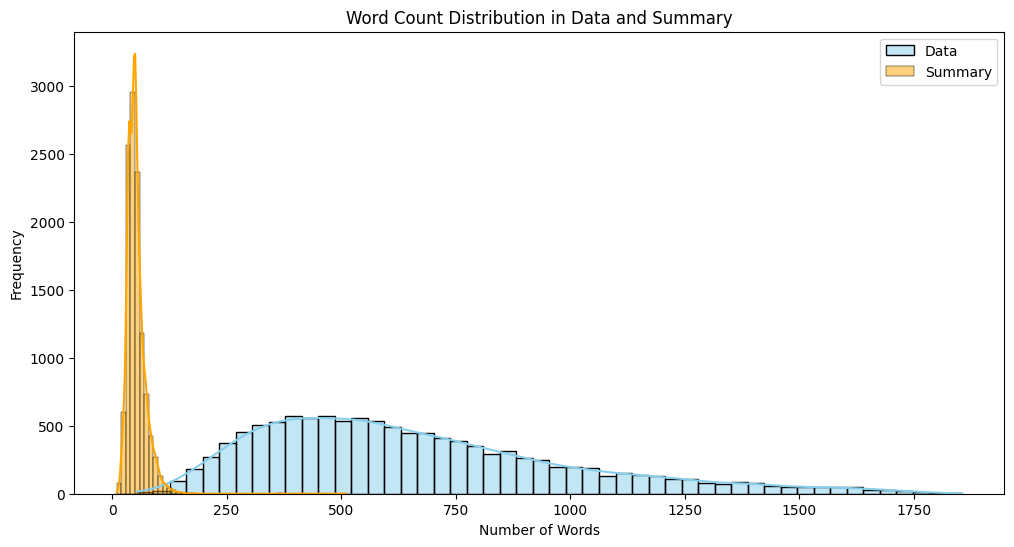

In [16]:
# Step 1: Count number of words in each row
df_test['data_word_count'] = df_test['text_clean'].apply(lambda x: len(str(x).split()))
df_test['summary_word_count'] = df_test['summary_clean'].apply(lambda x: len(str(x).split()))

# Step 2: Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_test['data_word_count'], bins=50, kde=True, color='skyblue', label='Data')
sns.histplot(df_test['summary_word_count'], bins=50, kde=True, color='orange', label='Summary')
plt.title("Word Count Distribution in Data and Summary")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [17]:
text_count = []
summary_count = []

In [18]:
for sent in df_train['text_clean']:
    text_count.append(len(sent.split()))

for sent in df_train['summary_clean']:
    summary_count.append(len(sent.split()))

for sent in df_val['text_clean']:
    text_count.append(len(sent.split()))

for sent in df_val['summary_clean']:
    summary_count.append(len(sent.split()))

for sent in df_test['text_clean']:
    text_count.append(len(sent.split()))

for sent in df_test['summary_clean']:
    summary_count.append(len(sent.split()))


In [19]:
merge_data= pd.DataFrame()
merge_data['text_clean'] = text_count
merge_data['summary_clean'] = summary_count

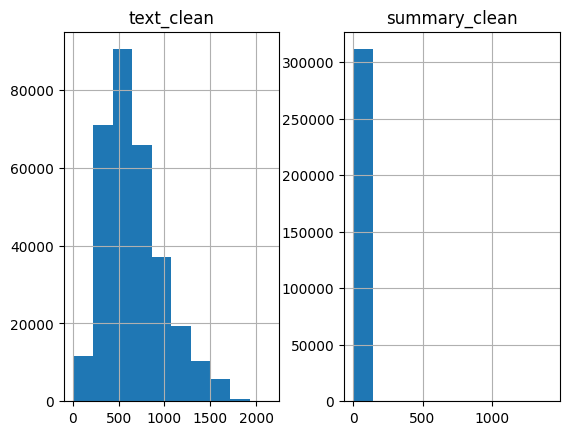

In [20]:
merge_data.hist(bins = 10)
plt.show()

In [21]:
# Check how much % of susummary_cleanmmary have 0-70 words
cnt = 0
for i in df_train['summary_clean']:
    if (len(i.split()) <= 70):
        cnt = cnt + 1
print(cnt / len(df_train['summary_clean']))

# Check how much % of text have 0-1100 words
cnt = 0
for i in df_train['text_clean']:
    if(len(i.split())<=1100):
        cnt=cnt+1
print(cnt/len(df_train['text_clean']))

0.8836590471347519
0.8943377694496591


In [22]:
# Check how much % of susummary_cleanmmary have 0-70 words
cnt = 0
for i in df_val['summary_clean']:
    if (len(i.split()) <= 70):
        cnt = cnt + 1
print(cnt / len(df_val['summary_clean']))

# Check how much % of text have 0-1100 words
cnt = 0
for i in df_val['text_clean']:
    if(len(i.split())<=1100):
        cnt=cnt+1
print(cnt/len(df_val['text_clean']))

0.8017654099341711
0.8913076002393776


In [23]:
# Check how much % of susummary_cleanmmary have 0-70 words
cnt = 0
for i in df_test['summary_clean']:
    if (len(i.split()) <= 70):
        cnt = cnt + 1
print(cnt / len(df_test['summary_clean']))

# Check how much % of text have 0-1100 words
cnt = 0
for i in df_test['text_clean']:
    if(len(i.split())<=1100):
        cnt=cnt+1
print(cnt/len(df_test['text_clean']))

0.8496953872932985
0.8829416884247171


so now we would only train and validate on those samples which has the summary_clean <= 70 and text_clean <= 1100

In [24]:
# max_text_len=65
# max_summary_len=15

max_summary_len=70
max_text_len=1100

In [25]:
cleaned_text_train = np.array(df_train['text_clean'])
cleaned_summary_train = np.array(df_train['summary_clean'])

short_text = []
short_summary = []

for i in range(len(cleaned_text_train)):
    if(len(cleaned_summary_train[i].split()) <= max_summary_len and len(cleaned_text_train[i].split()) <= max_text_len):
        short_text.append(cleaned_text_train[i])
        short_summary.append(cleaned_summary_train[i])

df_train_post = pd.DataFrame({'text':short_text,'summary':short_summary})

In [26]:
print(df_train_post.info())
df_train_post.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231545 entries, 0 to 231544
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     231545 non-null  object
 1   summary  231545 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB
None


,text,summary
0,by associated press published 14 11 est 25 october 2013 updated 15 36 est 25 october 2013 the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda pictured of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis state immunization program manager molly howell says the risk is low but officials feel it important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis the diocese says he contracted the infection through contaminated food while attending conference for newly ordained bishops in italy last month symptoms of hepatitis include fever tiredness loss of appetite nausea and abdominal discomfort fargo catholic diocese in north dakota pictured is where the bishop is located,_START_ bishop john folda of north dakota is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in fargo grand forks and jamestown could have been exposed _END_
1,cnn ralph mata was an internal affairs lieutenant for the miami dade police department working in the division that investigates allegations of wrongdoing by cops outside the office authorities allege that the 45 year old longtime officer worked with drug trafficking organization to help plan murder plot and get guns criminal complaint unsealed in district court in new jersey tuesday accuses mata also known as the milk man of using his role as police officer to help the drug trafficking organization in exchange for money and gifts including rolex watch in one instance the complaint alleges mata arranged to pay two assassins to kill rival drug dealers the killers would pose as cops pulling over their targets before shooting them according to the complaint ultimately the organization decided not to move forward with the murder plot but mata still received payment for setting up the meetings federal prosecutors said in statement the complaint also alleges that mata used his police badge to purchase weapons for drug traffickers mata according to the complaint then used contacts at the airport to transport the weapons in his carry on luggage on trips from miami to the dominican republic court documents released by investigators do not specify the name of the drug trafficking organization with which mata allegedly conspired but says the organization has been importing narcotics from places such as ecuador and the dominican republic by hiding them inside shipping containers containing pallets of produce including bananas the organization has been distributing narcotics in new jersey and elsewhere the complaint says authorities arrested mata on tuesday in miami gardens florida it was not immediately clear whether mata has an attorney and police officials could not be immediately reached for comment mata has worked for the miami dade police department since 1992 including directing investigations in miami gardens and working as lieutenant in the unit at miami international airport according to the complaint since march 2010 he had been working in the internal affairs division mata faces charges of aiding and abetting conspiracy to distribute cocaine conspiring to distribute cocaine and engaging in monetary transactions in property derived from specified unlawful activity he is scheduled to appear in federal court in florida on wednesday if convicted mata could face life in prison cnn suzanne presto contributed to this report,_START_ criminal complaint cop used his role to help cocaine traffickers ralph mata an internal affairs lieutenant allegedly helped grou

In [27]:
cleaned_text_val = np.array(df_val['text_clean'])
cleaned_summary_val = np.array(df_val['summary_clean'])

short_text = []
short_summary = []

for i in range(len(cleaned_text_val)):
    if(len(cleaned_summary_val[i].split()) <= max_summary_len and len(cleaned_text_val[i].split()) <= max_text_len):
        short_text.append(cleaned_text_val[i])
        short_summary.append(cleaned_summary_val[i])

df_val_post = pd.DataFrame({'text':short_text,'summary':short_summary})

In [28]:
print(df_val_post.info())
df_val_post.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9874 entries, 0 to 9873
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     9874 non-null   object
 1   summary  9874 non-null   object
dtypes: object(2)
memory usage: 154.4+ KB
None


,text,summary
0,sally forrest an actress dancer who graced the silver screen throughout the 40s and 50s in mgm musicals and films such as the 1956 noir while the city sleeps died on march 15 at her home in beverly hills california forrest whose birth name was katherine feeney was 86 and had long battled cancer her publicist judith goffin announced the news thursday scroll down for video actress sally forrest was in the 1951 ida lupino directed film hard fast and beautiful left and the 1956 fritz lang movie while the city sleeps san diego native forrest became protege of hollywood trailblazer ida lupino who cast her in starring roles in films including the critical and commercial success not wanted never fear and hard fast and beautiful some of forrest other film credits included bannerline son of sinbad and excuse my dust according to her imdb page the page also indicates forrest was in multiple climax and rawhide television episodes forrest appeared as herself in an episode of the ed sullivan show and three episodes of the dinah shore chevy show her imdb page says she also starred in broadway production of the seven year itch city news service reported that other stage credits included as you like it no no nanette and damn yankees forrest married writer producer milo frank in 1951 he died in 2004 she is survived by her niece sharon durham and nephews michael and mark feeney career san diego native forrest became protege of hollywood trailblazer ida lupino who cast her in starring roles in films,_START_ sally forrest an actress dancer who graced the silver screen throughout the 40s and 50s in mgm musicals and films died on march 15 forrest whose birth name was katherine feeney had long battled cancer san diego native forrest became protege of hollywood trailblazer ida lupino who cast her in starring roles in films _END_
1,middle school teacher in china has inked hundreds of sketches that are beyond be leaf politics teacher wang lian 35 has created 1000 stunning ink drawings covering subjects as varied as cartoon characters and landscapes to animals birds according to the people daily online the intricate scribbles on leaves feature wang favourite sites across the city of nanjing which include the presidential palace yangtze river bridge the ancient jiming temple and the qinhuai river natural canvas artist and teacher wang lian has done hundreds of drawings like this temple on leaves she collects in the park and on the streets delicate she uses an ink pen to gently draw the local scenes and buildings on the dried out leaves although teaching politics is my job drawing is my passion and hobby said wang first tried drawing on leaves about 10 years ago and fell in love with it as an art form immediately it like drawing on very old parchment paper you have to be really careful that you don damage the leaf because it is very fragile and this helps focus your attention and abilities wang started giving the drawings away on christmas eve in 2012 when her junior high school son came home saying he wanted to prepare some gifts for his classmates being an avid painter wang decided to give her son friends unique presents of gingko leaf paintings wang loves gingko leaves and will often pick them up along gingko avenue near to her school in nanjing in east china jiangsu province every autumn she collects about 000 leaves from the ground to ensure she has enough to cover spoils too intricate teacher wang has drawn hundreds of local scenes on leaves she has collected from the park hobby the artist collects leaves every autumn and dries them out so she can sketch these impressive building scenes the colour and shape of gingko leaves are particularly beautiful she said need to collect around 2000 leaves because this will include losses she takes them home where she then presses them between the pages of books luckily have quite lot of books and try to use old ones or ones that ve already read so don end up with nothing to read once they are dri

In [29]:
x_train = df_train_post['text'].values
y_train = df_train_post['summary'].values

x_val = df_val_post['text'].values
y_val = df_val_post['summary'].values

x_test = df_test['text_clean'].values
y_test = df_test['summary_clean'].values

In [30]:
def check_start_end_tokens(df, column='summary'):
    missing_start = df[~df[column].str.strip().str.startswith('_START_')]
    missing_end = df[~df[column].str.strip().str.endswith('_END_')]

    print(f"Total rows: {len(df)}")
    print(f"🟡 Rows missing _START_: {len(missing_start)}")
    print(f"🔴 Rows missing _END_: {len(missing_end)}")
    
    if len(missing_start) > 0:
        print("→ Sample missing _START_:\n", missing_start[column].head(), "\n")

    if len(missing_end) > 0:
        print("→ Sample missing _END_:\n", missing_end[column].head(), "\n")

    return missing_start, missing_end

print("🔍 Checking df_train_post:")
missing_start_train, missing_end_train = check_start_end_tokens(df_train_post)

print("🔍 Checking df_val_post:")
missing_start_val, missing_end_val = check_start_end_tokens(df_val_post)

print("🔍 Checking df_test:")
missing_start_test, missing_end_test = check_start_end_tokens(df_test, 'summary_clean')


🔍 Checking df_train_post:
Total rows: 231545
🟡 Rows missing _START_: 0
🔴 Rows missing _END_: 0
🔍 Checking df_val_post:
Total rows: 9874
🟡 Rows missing _START_: 0
🔴 Rows missing _END_: 0
🔍 Checking df_test:
Total rows: 11490
🟡 Rows missing _START_: 0
🔴 Rows missing _END_: 0


In [31]:
x_train[0]

'by associated press published 14 11 est 25 october 2013 updated 15 36 est 25 october 2013 the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda pictured of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis state immunization program manager molly howell says the risk is low but officials feel it important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis the diocese says he contracted the infection through contaminated food while attending conference for newly ordained bishops in italy last month symptoms of h

In [32]:
y_train[0]

'_START_ bishop john folda of north dakota is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in fargo grand forks and jamestown could have been exposed _END_'

In [33]:
# # ✅ Modified filters to preserve `_`
# custom_filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n'

# # Create tokenizer
# tokenizer = Tokenizer(filters=custom_filters)

# # Example summary-like sentence
# texts = ["_START_ this is a summary _END_"]

# # Fit tokenizer
# tokenizer.fit_on_texts(texts)

# # Print word index to verify
# print("Word Index:", tokenizer.word_index)

# # Check specifically for the special tokens
# print("_start_ in tokenizer:", "_start_" in tokenizer.word_index)
# print("_end_ in tokenizer:", "_end_" in tokenizer.word_index)

# # Tokenized sequence
# print("Tokenized sequence:", tokenizer.texts_to_sequences(texts))

In [34]:
# Parameters
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
MAX_LEN = 70
MAX_VOCAB_SIZE = 30000  # or 10000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Set tokenizer with num_words and oov_token
# input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
# output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")

# Remove `_` from filters so special tokens like _START_ are preserved
filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n'  # Default filters without underscore

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>", filters=filters)
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>", filters=filters)

# Step 2: Fit on your training text
input_tokenizer.fit_on_texts(x_train)
output_tokenizer.fit_on_texts(y_train)

# ⚠️ Step 3: Manually truncate word_index to respect num_words
# input_tokenizer.word_index = {word: idx for word, idx in input_tokenizer.word_index.items() if idx < MAX_VOCAB_SIZE}
# output_tokenizer.word_index = {word: idx for word, idx in output_tokenizer.word_index.items() if idx < MAX_VOCAB_SIZE}

# Step 3: Manually truncate word_index while preserving special tokens
SPECIAL_TOKENS = ["_START_", "_END_"]
input_tokenizer.word_index = {
    word: idx for word, idx in input_tokenizer.word_index.items()
    if idx < MAX_VOCAB_SIZE or word in SPECIAL_TOKENS
}
output_tokenizer.word_index = {
    word: idx for word, idx in output_tokenizer.word_index.items()
    if idx < MAX_VOCAB_SIZE or word in SPECIAL_TOKENS
}

# Step 4: Make sure OOV token is preserved
input_tokenizer.word_index[input_tokenizer.oov_token] = MAX_VOCAB_SIZE
output_tokenizer.word_index[output_tokenizer.oov_token] = MAX_VOCAB_SIZE

# Step 5: Tokenize and pad
x_train_seq = pad_sequences(input_tokenizer.texts_to_sequences(x_train), maxlen=MAX_LEN, padding='post')
x_val_seq   = pad_sequences(input_tokenizer.texts_to_sequences(x_val),   maxlen=MAX_LEN, padding='post')
x_test_seq  = pad_sequences(input_tokenizer.texts_to_sequences(x_test),  maxlen=MAX_LEN, padding='post')

y_train_seq = pad_sequences(output_tokenizer.texts_to_sequences(y_train), maxlen=MAX_LEN, padding='post')
y_val_seq   = pad_sequences(output_tokenizer.texts_to_sequences(y_val),   maxlen=MAX_LEN, padding='post')
y_test_seq  = pad_sequences(output_tokenizer.texts_to_sequences(y_test),  maxlen=MAX_LEN, padding='post')

# Step 6: Final vocab sizes (True limit + OOV)
input_vocab_size = MAX_VOCAB_SIZE + 1
output_vocab_size = MAX_VOCAB_SIZE + 1
pad_token_id = output_tokenizer.word_index["<OOV>"]


In [35]:
print("Input vocab size", input_vocab_size)
print("Output vocab size", output_vocab_size)


Input vocab size 30001
Output vocab size 30001


In [36]:
print("Word Index Sample:", list(input_tokenizer.word_index.items())[:10])
print("Sequence Sample:", input_tokenizer.texts_to_sequences(["this is a very rareword123"]))


Word Index Sample: [('<OOV>', 30000), ('the', 2), ('to', 3), ('of', 4), ('and', 5), ('in', 6), ('for', 7), ('that', 8), ('was', 9), ('on', 10)]
Sequence Sample: [[30, 11, 30000, 110, 30000]]


In [37]:
print("_start_ in output_tokenizer:", "_start_" in output_tokenizer.word_index)
print("_end_ in output_tokenizer:", "_end_" in output_tokenizer.word_index)

print("_start_ in input_tokenizer:", "_start_" in input_tokenizer.word_index)
print("_end_ in input_tokenizer:", "_end_" in input_tokenizer.word_index)


_start_ in output_tokenizer: True
_end_ in output_tokenizer: True
_start_ in input_tokenizer: False
_end_ in input_tokenizer: False


In [38]:
# Dataset and Dataloader
class TextSummaryDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_dataset = TextSummaryDataset(x_train_seq, y_train_seq)
val_dataset = TextSummaryDataset(x_val_seq, y_val_seq)
test_dataset = TextSummaryDataset(x_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [39]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # self.attn = nn.Linear(enc_hid_dim*2 + dec_hid_dim, dec_hid_dim) # old - bad performance 
        self.attn = nn.Linear(enc_hid_dim*2 + dec_hid_dim + 1, dec_hid_dim)  # +1 for coverage
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs, coverage):
        decoder_hidden = decoder_hidden[-1].unsqueeze(1).repeat(1, encoder_outputs.shape[1], 1)
        # old - bad performance 
        # energy = torch.tanh(self.attn(torch.cat((decoder_hidden, encoder_outputs), dim=2)))
        # new - add coverage 
        coverage = coverage.unsqueeze(2)  # [B, src_len, 1]
        energy = torch.tanh(self.attn(torch.cat((decoder_hidden, encoder_outputs, coverage), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.lstm = nn.LSTM(enc_hid_dim*2 + emb_dim, dec_hid_dim, batch_first=True)
        self.fc = nn.Linear(enc_hid_dim*2 + dec_hid_dim + emb_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs, coverage):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        # a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        a = self.attention(hidden, encoder_outputs, coverage).unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, _) = self.lstm(rnn_input)
        pred = self.fc(torch.cat((output.squeeze(1), weighted.squeeze(1), embedded.squeeze(1)), dim=1))
        # add coverage 
        coverage = coverage + a.squeeze(1)  # update coverage
        # return pred, hidden, a.squeeze(1) # old 
        return pred, hidden, a.squeeze(1), coverage # add coverage 


In [40]:
# Evaluation Metrics
rouge = Rouge()

def evaluate_metrics(preds, refs):
    bleu_score = np.mean([sentence_bleu([ref.split()], pred.split()) for pred, ref in zip(preds, refs)])
    rouge_scores = rouge.get_scores(preds, refs, avg=True)
    return bleu_score, rouge_scores

# Updated training function with optimizer, scheduler, and model saving
def train_model(encoder, decoder, train_loader, val_loader, optimizer, criterion, num_epochs=5, save_path="seq2seq_model.pth", coverage_loss_weight=1.0):
    encoder.to(DEVICE)
    decoder.to(DEVICE)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        total_train_loss = 0

        for i, (src, trg) in enumerate(train_loader):
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            optimizer.zero_grad()

            enc_outputs, hidden, cell = encoder(src)
            input_tok = trg[:, 0]
            coverage = torch.zeros(src.size(0), enc_outputs.size(1)).to(DEVICE) # add
            
            loss = 0

            for t in range(1, trg.shape[1]):
                # output, hidden, _ = decoder(input_tok, hidden, enc_outputs) # old 
                
                # output, hidden, _, coverage = decoder(input_tok, hidden, enc_outputs, coverage)
                # loss += criterion(output, trg[:, t])

                output, hidden, attn, coverage = decoder(input_tok, hidden, enc_outputs, coverage)

                # Compute step-level coverage loss
                step_coverage_loss = torch.min(attn, coverage).sum(dim=1).mean()
                
                # Total loss = prediction loss + coverage loss
                loss += criterion(output, trg[:, t]) + coverage_loss_weight * step_coverage_loss
                
                input_tok = trg[:, t]

            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() / trg.shape[1]

            if i % 100 == 0:
                print(f"Epoch {epoch+1}, Step {i}, Train Loss: {loss.item()/trg.shape[1]:.4f}")

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation loop
        encoder.eval()
        decoder.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, trg in val_loader:
                src, trg = src.to(DEVICE), trg.to(DEVICE)
                enc_outputs, hidden, cell = encoder(src)
                input_tok = trg[:, 0]
                coverage = torch.zeros(src.size(0), enc_outputs.size(1)).to(DEVICE) # add 
                loss = 0

                for t in range(1, trg.shape[1]):
                    # output, hidden, _ = decoder(input_tok, hidden, enc_outputs) # old 
                    output, hidden, _, coverage = decoder(input_tok, hidden, enc_outputs, coverage) # new 
                    loss += criterion(output, trg[:, t])
                    input_tok = trg[:, t]

                total_val_loss += loss.item() / trg.shape[1]

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"📘 Epoch {epoch+1} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        scheduler.step()

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
            print(f"✅ Model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

    print("🏁 Training completed.")
    return encoder, decoder, history

# Evaluation on test set
def evaluate_model(encoder, decoder, test_loader, output_tokenizer):
    encoder.eval()
    decoder.eval()

    all_preds = []
    all_refs = []

    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)

            enc_outputs, hidden, cell = encoder(src)
            input_tok = trg[:, 0]
            preds = []

            # add 
            coverage = torch.zeros(src.size(0), enc_outputs.size(1)).to(DEVICE)

            for t in range(1, trg.shape[1]):
                # output, hidden, _ = decoder(input_tok, hidden, enc_outputs) # old 
                output, hidden, _, coverage = decoder(input_tok, hidden, enc_outputs, coverage)
                input_tok = output.argmax(1)
                preds.append(input_tok.unsqueeze(1))

            preds = torch.cat(preds, dim=1)
            pred_texts = [" ".join([output_tokenizer.index_word.get(idx.item(), "") for idx in seq]) for seq in preds]
            ref_texts = [" ".join([output_tokenizer.index_word.get(idx.item(), "") for idx in seq]) for seq in trg]

            all_preds.extend(pred_texts)
            all_refs.extend(ref_texts)

    # bleu_score, rouge_scores = evaluate_metrics(all_preds, all_refs)
    # print(f"🧪 BLEU Score: {bleu_score:.4f}")
    # print("📊 ROUGE Scores:", rouge_scores)
    # return bleu_score, rouge_scores

    # Compute metrics
    bleu_score, rouge_scores = evaluate_metrics(all_preds, all_refs)

    print(f"\n🧪 BLEU Score: {bleu_score:.4f}")

    print("📊 ROUGE Scores:")
    print(f" - ROUGE-1: Precision={rouge_scores['rouge-1']['p']:.4f}, Recall={rouge_scores['rouge-1']['r']:.4f}, F1={rouge_scores['rouge-1']['f']:.4f}")
    print(f" - ROUGE-2: Precision={rouge_scores['rouge-2']['p']:.4f}, Recall={rouge_scores['rouge-2']['r']:.4f}, F1={rouge_scores['rouge-2']['f']:.4f}")
    print(f" - ROUGE-L: Precision={rouge_scores['rouge-l']['p']:.4f}, Recall={rouge_scores['rouge-l']['r']:.4f}, F1={rouge_scores['rouge-l']['f']:.4f}")

    return bleu_score, rouge_scores

# Real-world inference
def summarize_text(input_text, encoder, decoder, input_tokenizer, output_tokenizer, max_len=MAX_LEN, plot_flag=False):
    encoder.eval()
    decoder.eval()

    # ✅ Get special token IDs from output tokenizer
    start_token_id = output_tokenizer.word_index.get("_start_")
    end_token_id = output_tokenizer.word_index.get("_end_")

    if start_token_id is None or end_token_id is None:
        raise ValueError("Make sure '_START_' and '_END_' tokens are included in your summary_clean before fitting the tokenizer.")

    # ✅ Tokenize input text using input tokenizer
    input_ids = input_tokenizer.texts_to_sequences([input_text])[0]

    # Optionally wrap with _START_ and _END_ if input tokenizer was trained that way (not required)
    # input_ids = [input_tokenizer.word_index.get("_START_", MAX_VOCAB_SIZE)] + input_ids + [input_tokenizer.word_index.get("_END_", MAX_VOCAB_SIZE)]

    input_tensor = torch.tensor(
        pad_sequences([input_ids], maxlen=max_len, padding='post'),
        dtype=torch.long
    ).to(DEVICE)

    input_tok = torch.tensor([start_token_id]).to(DEVICE)
    generated_ids = []
    attention_weights = []

    with torch.no_grad():
        enc_outputs, hidden, cell = encoder(input_tensor)
        coverage = torch.zeros(1, enc_outputs.size(1)).to(DEVICE) # add 

        for _ in range(max_len):
            # output, hidden, attn = decoder(input_tok, hidden, enc_outputs)  # make sure decoder returns attn # old 
            output, hidden, attn, coverage = decoder(input_tok, hidden, enc_outputs, coverage)
            next_token = output.argmax(1).item()

            if next_token == end_token_id:
                break

            generated_ids.append(next_token)
            attention_weights.append(attn.squeeze(0).cpu().numpy())  # shape: [src_len]
            input_tok = torch.tensor([next_token]).to(DEVICE)

    summary_words = [output_tokenizer.index_word.get(idx, "") for idx in generated_ids]
    input_words = [input_tokenizer.index_word.get(idx, "") for idx in input_ids][:max_len]

    # ✅ Visualize attention
    if attention_weights and plot_flag:
        attn_matrix = np.stack(attention_weights)
        plt.figure(figsize=(10, 6))
        sns.heatmap(attn_matrix, xticklabels=input_words, yticklabels=summary_words, cmap='viridis')
        plt.xlabel("Input Tokens")
        plt.ylabel("Generated Summary Tokens")
        plt.title("Attention Heatmap")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return " ".join(summary_words).strip()



In [41]:
'_end_' in output_tokenizer.word_index

True

In [42]:
def beam_search_decode(
    encoder,
    decoder,
    src,
    output_tokenizer,
    beam_width=3,
    max_len=50,
    repetition_penalty=1.0,
    normalize_by_length=True,
    block_ngram_repeat=True,
    ngram_size=3
):
    encoder.eval()
    decoder.eval()
    src = src.to(DEVICE)

    with torch.no_grad():
        enc_outputs, hidden, cell = encoder(src)
        coverage = torch.zeros(1, enc_outputs.size(1)).to(DEVICE)

        start_token = output_tokenizer.word_index["_start_"]
        end_token = output_tokenizer.word_index["_end_"]

        beams = [([start_token], 0.0, hidden, coverage)]

        for _ in range(max_len):
            new_beams = []

            for tokens, score, hidden, coverage in beams:
                input_tok = torch.tensor([tokens[-1]]).to(DEVICE)
                output, hidden, attn_weights, coverage = decoder(input_tok, hidden, enc_outputs, coverage)

                probs = F.log_softmax(output, dim=1).squeeze(0)

                # Apply repetition penalty
                for i, token in enumerate(tokens):
                    probs[token] -= repetition_penalty

                # Get top-k tokens
                topk_probs, topk_idx = probs.topk(beam_width)

                for i in range(beam_width):
                    next_token = topk_idx[i].item()
                    next_score = score + topk_probs[i].item()
                    next_tokens = tokens + [next_token]

                    # Optional: block repeated n-grams
                    if block_ngram_repeat and has_repeat_ngram(next_tokens, n=ngram_size):
                        continue

                    new_beams.append((next_tokens, next_score, hidden, coverage))

            # Keep top-k based on normalized or raw score
            if normalize_by_length:
                beams = sorted(new_beams, key=lambda x: x[1] / len(x[0]), reverse=True)[:beam_width]
            else:
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

            # Early stop if all beams ended
            if all(tokens[-1] == end_token for tokens, _, _, _ in beams):
                break

        # Final best sequence
        best_tokens = beams[0][0]
        decoded = [
            output_tokenizer.index_word.get(idx, "")
            for idx in best_tokens[1:]
            if idx != end_token
        ]
        return " ".join(decoded)

# Helper to block repeated n-grams
def has_repeat_ngram(tokens, n=3):
    ngrams = set()
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i+n])
        if ngram in ngrams:
            return True
        ngrams.add(ngram)
    return False

def evaluate_model_with_beam_search(encoder, decoder, test_loader, output_tokenizer, beam_width=3):
    all_preds = []
    all_refs = []

    for src, trg in test_loader:
        src = src.to(DEVICE)
        for i in range(src.size(0)):
            pred_text = beam_search_decode(encoder, decoder, src[i:i+1], output_tokenizer, beam_width)
            ref_text = " ".join([output_tokenizer.index_word.get(idx.item(), "") for idx in trg[i] if idx.item() != pad_token_id])
            all_preds.append(pred_text)
            all_refs.append(ref_text)

    bleu_score, rouge_scores = evaluate_metrics(all_preds, all_refs)

    print(f"\n🧪 BLEU Score: {bleu_score:.4f}")
    print("📊 ROUGE Scores:")
    print(f" - ROUGE-1: Precision={rouge_scores['rouge-1']['p']:.4f}, Recall={rouge_scores['rouge-1']['r']:.4f}, F1={rouge_scores['rouge-1']['f']:.4f}")
    print(f" - ROUGE-2: Precision={rouge_scores['rouge-2']['p']:.4f}, Recall={rouge_scores['rouge-2']['r']:.4f}, F1={rouge_scores['rouge-2']['f']:.4f}")
    print(f" - ROUGE-L: Precision={rouge_scores['rouge-l']['p']:.4f}, Recall={rouge_scores['rouge-l']['r']:.4f}, F1={rouge_scores['rouge-l']['f']:.4f}")
    
    return bleu_score, rouge_scores

def summarize_text_beam_search(
    input_text,
    encoder,
    decoder,
    input_tokenizer,
    output_tokenizer,
    max_len=50,
    beam_width=5,
    repetition_penalty=1.2,
    ngram_block=3
):
    encoder.eval()
    decoder.eval()

    # Token IDs
    start_token_id = output_tokenizer.word_index.get("_start_")
    end_token_id = output_tokenizer.word_index.get("_end_")
    if start_token_id is None or end_token_id is None:
        raise ValueError("Tokenizer must include _start_ and _end_ tokens.")

    # Tokenize input
    input_ids = input_tokenizer.texts_to_sequences([input_text])[0]
    input_tensor = torch.tensor(
        pad_sequences([input_ids], maxlen=max_len, padding='post'),
        dtype=torch.long
    ).to(DEVICE)

    with torch.no_grad():
        enc_outputs, hidden, cell = encoder(input_tensor)
        coverage = torch.zeros(1, enc_outputs.size(1)).to(DEVICE)

        beams = [([start_token_id], 0.0, hidden, coverage)]

        for _ in range(max_len):
            new_beams = []

            for tokens, score, hidden, coverage in beams:
                if tokens[-1] == end_token_id:
                    new_beams.append((tokens, score, hidden, coverage))
                    continue

                input_tok = torch.tensor([tokens[-1]]).to(DEVICE)
                output, hidden_new, attn, coverage_new = decoder(
                    input_tok, hidden, enc_outputs, coverage
                )

                probs = F.log_softmax(output, dim=1)
                topk_probs, topk_ids = probs.topk(beam_width)

                # print("Top-5 tokens:", [output_tokenizer.index_word.get(idx.item(), "") for idx in topk_ids[0]])

                for i in range(beam_width):
                    next_token = topk_ids[0][i].item()
                    next_score = topk_probs[0][i].item()

                    # Apply repetition penalty
                    if next_token in tokens:
                        next_score -= repetition_penalty

                    # N-gram blocking
                    if has_repeat_ngram(tokens + [next_token]):
                        continue

                    new_tokens = tokens + [next_token]
                    normalized_score = (score + next_score) / len(new_tokens)

                    new_beams.append(
                        (new_tokens, normalized_score, hidden_new.clone(), coverage_new.clone())
                    )

            # beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
            if new_beams:
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
            else:
                break

            if all(tokens[-1] == end_token_id for tokens, _, _, _ in beams):
                break

        best_tokens = beams[0][0]
        summary_words = [
            output_tokenizer.index_word.get(idx, "") 
            for idx in best_tokens[1:] 
            if idx != end_token_id
        ]
        return " ".join(summary_words).strip()



In [43]:
attention = BahdanauAttention(enc_hid_dim=HIDDEN_DIM, dec_hid_dim=HIDDEN_DIM)
encoder = Encoder(input_dim=input_vocab_size, emb_dim=EMBEDDING_DIM, hid_dim=HIDDEN_DIM)
decoder = Decoder(output_dim=output_vocab_size, emb_dim=EMBEDDING_DIM, enc_hid_dim=HIDDEN_DIM, dec_hid_dim=HIDDEN_DIM, attention=attention)


In [44]:
# optimizer = torch.optim.Adam(
#     list(encoder.parameters()) + list(decoder.parameters()),
#     lr=1e-3,
#     weight_decay=1e-5
# )

optimizer = torch.optim.Adam(
    params=list(encoder.parameters()) + list(decoder.parameters())
)

# criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id) # bad performance 
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id, label_smoothing=0.184)


In [45]:
encoder, decoder, history = train_model(
    encoder,
    decoder,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    num_epochs=10,  
    save_path='best_seq2seq_model.pth',
    coverage_loss_weight=1.0
)


Epoch 1, Step 0, Train Loss: 11.1491
Epoch 1, Step 100, Train Loss: 6.6810
Epoch 1, Step 200, Train Loss: 6.6488
Epoch 1, Step 300, Train Loss: 6.9375
Epoch 1, Step 400, Train Loss: 6.5769
Epoch 1, Step 500, Train Loss: 6.6307
Epoch 1, Step 600, Train Loss: 6.5426
Epoch 1, Step 700, Train Loss: 6.5942
Epoch 1, Step 800, Train Loss: 6.4523
Epoch 1, Step 900, Train Loss: 6.5640
Epoch 1, Step 1000, Train Loss: 6.3978
Epoch 1, Step 1100, Train Loss: 6.4308
Epoch 1, Step 1200, Train Loss: 6.6673
Epoch 1, Step 1300, Train Loss: 6.3942
Epoch 1, Step 1400, Train Loss: 6.6197
Epoch 1, Step 1500, Train Loss: 6.4132
Epoch 1, Step 1600, Train Loss: 6.2542
Epoch 1, Step 1700, Train Loss: 6.3547
Epoch 1, Step 1800, Train Loss: 6.2719
Epoch 1, Step 1900, Train Loss: 6.3904
Epoch 1, Step 2000, Train Loss: 6.1915
Epoch 1, Step 2100, Train Loss: 6.2141
Epoch 1, Step 2200, Train Loss: 6.4067
Epoch 1, Step 2300, Train Loss: 6.2806
Epoch 1, Step 2400, Train Loss: 6.2326
Epoch 1, Step 2500, Train Loss: 6.15

In [46]:
def plot_loss(history):
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [47]:
history

{'train_loss': [6.41035104821025,
  6.097260965182962,
  5.943560858133569,
  5.882906551763239,
  5.8094644070085755,
  5.782796619677076,
  5.744137240785411,
  5.731658298950605,
  5.711198105488616,
  5.7051777565901896],
 'val_loss': [5.353986782654084,
  5.247244448332191,
  5.207510553175409,
  5.199989123366397,
  5.1946796638734885,
  5.197971618933613,
  5.201410649031539,
  5.203327957364273,
  5.207467221027146,
  5.209844678184405]}

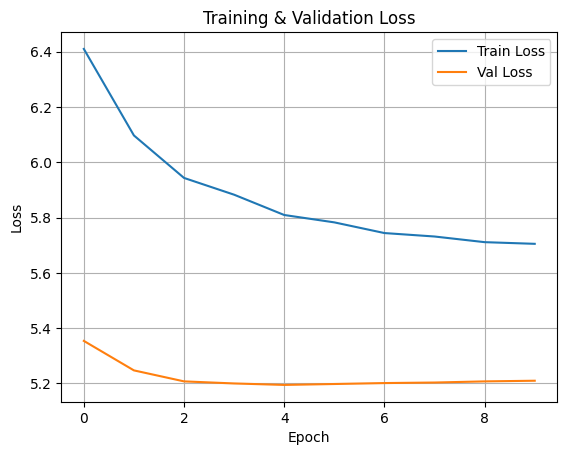

In [48]:
plot_loss(history)

In [49]:
bleu_score1, rouge_scores1 = evaluate_model(
    encoder,
    decoder,
    test_loader,
    output_tokenizer
)

bleu_score2, rouge_scores2 = evaluate_model_with_beam_search(
    encoder,
    decoder,
    test_loader,
    output_tokenizer
)

bleu_score3, rouge_scores3 = evaluate_model_with_beam_search(
    encoder,
    decoder,
    test_loader,
    output_tokenizer,
    beam_width=4
)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



🧪 BLEU Score: 0.2724
📊 ROUGE Scores:
 - ROUGE-1: Precision=0.4023, Recall=0.1192, F1=0.1744
 - ROUGE-2: Precision=0.0498, Recall=0.0171, F1=0.0244
 - ROUGE-L: Precision=0.3519, Recall=0.1017, F1=0.1491

🧪 BLEU Score: 0.3327
📊 ROUGE Scores:
 - ROUGE-1: Precision=0.2288, Recall=0.2156, F1=0.2177
 - ROUGE-2: Precision=0.0337, Recall=0.0307, F1=0.0313
 - ROUGE-L: Precision=0.1397, Recall=0.1325, F1=0.1331

🧪 BLEU Score: 0.3382
📊 ROUGE Scores:
 - ROUGE-1: Precision=0.2249, Recall=0.2185, F1=0.2178
 - ROUGE-2: Precision=0.0329, Recall=0.0309, F1=0.0312
 - ROUGE-L: Precision=0.1365, Recall=0.1339, F1=0.1327


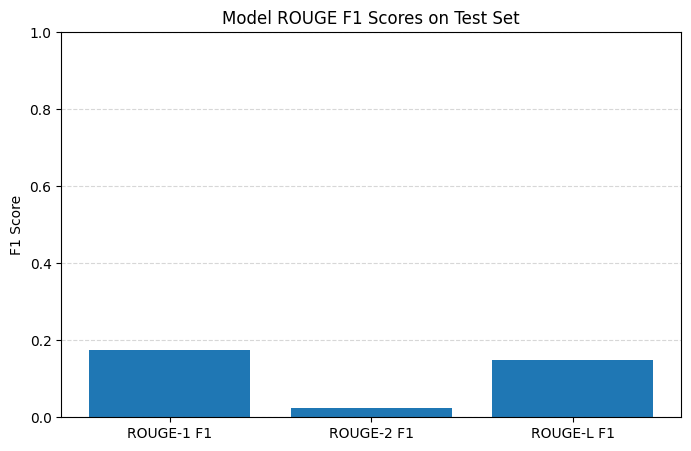

In [50]:
# Example — replace with your actual scores
rouge_1_f1 = rouge_scores1['rouge-1']['f']
rouge_2_f1 = rouge_scores1['rouge-2']['f']
rouge_l_f1 = rouge_scores1['rouge-l']['f']

# Labels and scores
labels = ['ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1']
scores = [rouge_1_f1, rouge_2_f1, rouge_l_f1]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(labels, scores)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Model ROUGE F1 Scores on Test Set")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

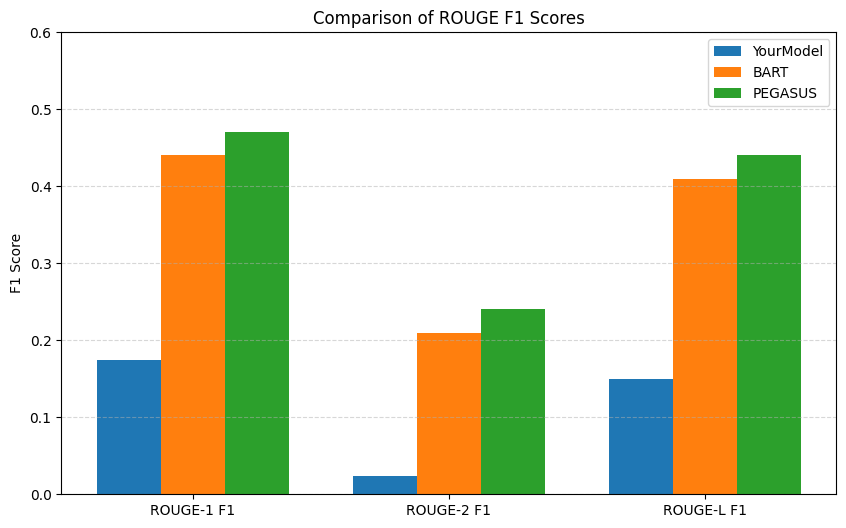

In [51]:
baseline_scores = {
    "YourModel": [rouge_1_f1, rouge_2_f1, rouge_l_f1],
    "BART": [0.44, 0.21, 0.41],
    "PEGASUS": [0.47, 0.24, 0.44]
}

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
for i, (model, vals) in enumerate(baseline_scores.items()):
    plt.bar(x + i*width, vals, width=width, label=model)

plt.xticks(x + width, labels)
plt.ylim(0, 0.6)
plt.ylabel("F1 Score")
plt.title("Comparison of ROUGE F1 Scores")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

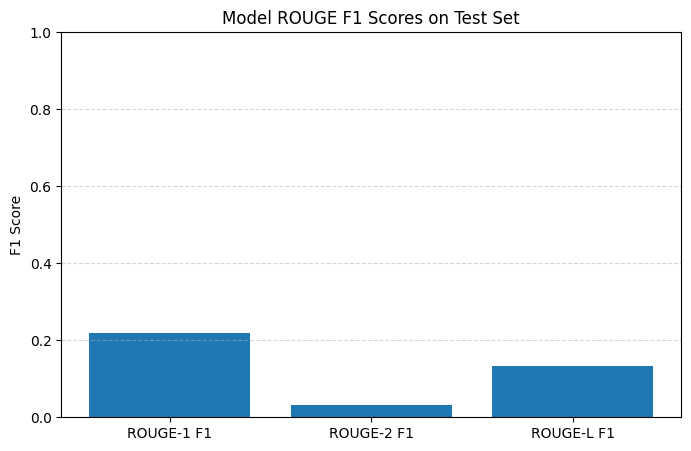

In [52]:
# Example — replace with your actual scores
rouge_1_f1 = rouge_scores2['rouge-1']['f']
rouge_2_f1 = rouge_scores2['rouge-2']['f']
rouge_l_f1 = rouge_scores2['rouge-l']['f']

# Labels and scores
labels = ['ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1']
scores = [rouge_1_f1, rouge_2_f1, rouge_l_f1]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(labels, scores)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Model ROUGE F1 Scores on Test Set")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

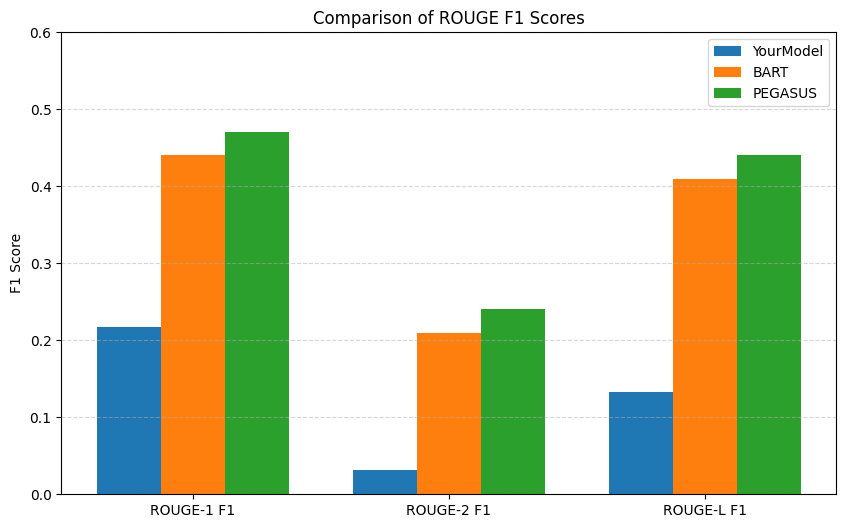

In [53]:
baseline_scores = {
    "YourModel": [rouge_1_f1, rouge_2_f1, rouge_l_f1],
    "BART": [0.44, 0.21, 0.41],
    "PEGASUS": [0.47, 0.24, 0.44]
}

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
for i, (model, vals) in enumerate(baseline_scores.items()):
    plt.bar(x + i*width, vals, width=width, label=model)

plt.xticks(x + width, labels)
plt.ylim(0, 0.6)
plt.ylabel("F1 Score")
plt.title("Comparison of ROUGE F1 Scores")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

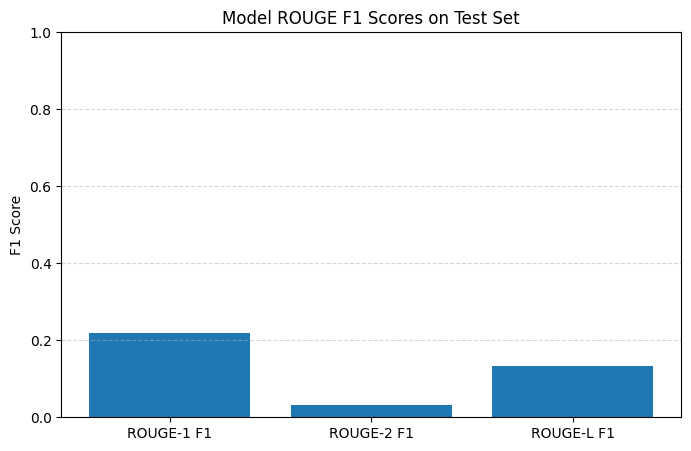

In [54]:
# Example — replace with your actual scores
rouge_1_f1 = rouge_scores3['rouge-1']['f']
rouge_2_f1 = rouge_scores3['rouge-2']['f']
rouge_l_f1 = rouge_scores3['rouge-l']['f']

# Labels and scores
labels = ['ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1']
scores = [rouge_1_f1, rouge_2_f1, rouge_l_f1]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(labels, scores)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Model ROUGE F1 Scores on Test Set")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

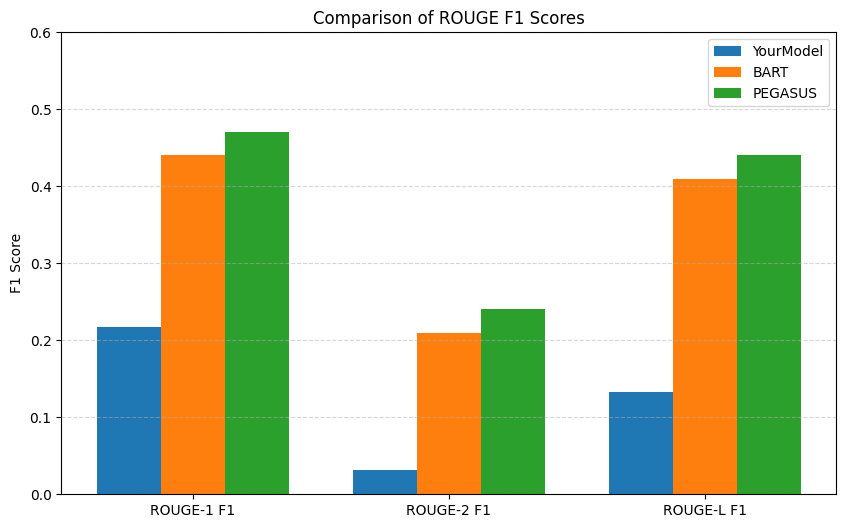

In [55]:
baseline_scores = {
    "YourModel": [rouge_1_f1, rouge_2_f1, rouge_l_f1],
    "BART": [0.44, 0.21, 0.41],
    "PEGASUS": [0.47, 0.24, 0.44]
}

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
for i, (model, vals) in enumerate(baseline_scores.items()):
    plt.bar(x + i*width, vals, width=width, label=model)

plt.xticks(x + width, labels)
plt.ylim(0, 0.6)
plt.ylabel("F1 Score")
plt.title("Comparison of ROUGE F1 Scores")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [56]:
print("\n🔍 Summarization on 10 Sample Test Inputs\n")

for i in range(10):
    # Raw input and reference
    raw_text = x_test[i]
    reference_summary = y_test[i]

    # Generate predicted summary
    predicted_summary = summarize_text(
        raw_text,
        encoder,
        decoder,
        input_tokenizer,
        output_tokenizer,
        max_len=int(1.2*len(reference_summary)), # old: MAX_LEN
        # beam_width=3
    )

    print(f"\nExample {i+1}")
    print(f"Input Text:\n{raw_text}\n")
    print(f"Ground Truth Summary:\n{reference_summary}\n")
    print(f"Predicted Summary:\n{predicted_summary}")
    print("-" * 80)


🔍 Summarization on 10 Sample Test Inputs


Example 1
Input Text:
ever noticed how plane seats appear to be getting smaller and smaller with increasing numbers of people taking to the skies some experts are questioning if having such packed out planes is putting passengers at risk they say that the shrinking space on aeroplanes is not only uncomfortable it putting our health and safety in danger more than squabbling over the arm rest shrinking space on planes putting our health and safety in danger this week consumer advisory group set up by the department of transportation said at public hearing that while the government is happy to set standards for animals flying on planes it doesn stipulate minimum amount of space for humans in world where animals have more rights to space and food than humans said charlie leocha consumer representative on the committee it is time that the dot and faa take stand for humane treatment of passengers but could crowding on planes lead to more serious is

In [57]:
example_input = "After attending the international conference on climate change, the prime minister emphasized the importance of transitioning to clean energy, urging other nations to commit to reducing greenhouse gas emissions and to invest in sustainable technologies that can secure the future of the planet for generations to come."

summary = summarize_text(
    example_input,
    encoder,
    decoder,
    input_tokenizer,
    output_tokenizer,
    max_len=int(0.2*len(example_input)), # old: MAX_LEN
    # beam_width=3
)

print("\nInput:", example_input)
print("Predicted Summary:", summary)



Input: After attending the international conference on climate change, the prime minister emphasized the importance of transitioning to clean energy, urging other nations to commit to reducing greenhouse gas emissions and to invest in sustainable technologies that can secure the future of the planet for generations to come.
Predicted Summary: the world leaders are in the world largest economy in the world largest economy is the first time to help reduce greenhouse gas emissions in the world to climate change in the world to climate change


In [58]:
print("\n🔍 Summarization on 10 Sample Test Inputs\n")

for i in range(10):
    # Raw input and reference
    raw_text = x_test[i]
    reference_summary = y_test[i]

    # Generate predicted summary
    predicted_summary = summarize_text_beam_search(
        raw_text,
        encoder,
        decoder,
        input_tokenizer,
        output_tokenizer,
        max_len=int(1.2*len(reference_summary)), # old: MAX_LEN
        beam_width=3
    )

    print(f"\nExample {i+1}")
    print(f"Input Text:\n{raw_text}\n")
    print(f"Ground Truth Summary:\n{reference_summary}\n")
    print(f"Predicted Summary:\n{predicted_summary}")
    print("-" * 80)


🔍 Summarization on 10 Sample Test Inputs


Example 1
Input Text:
ever noticed how plane seats appear to be getting smaller and smaller with increasing numbers of people taking to the skies some experts are questioning if having such packed out planes is putting passengers at risk they say that the shrinking space on aeroplanes is not only uncomfortable it putting our health and safety in danger more than squabbling over the arm rest shrinking space on planes putting our health and safety in danger this week consumer advisory group set up by the department of transportation said at public hearing that while the government is happy to set standards for animals flying on planes it doesn stipulate minimum amount of space for humans in world where animals have more rights to space and food than humans said charlie leocha consumer representative on the committee it is time that the dot and faa take stand for humane treatment of passengers but could crowding on planes lead to more serious is

In [59]:
example_input = "After attending the international conference on climate change, the prime minister emphasized the importance of transitioning to clean energy, urging other nations to commit to reducing greenhouse gas emissions and to invest in sustainable technologies that can secure the future of the planet for generations to come."

summary = summarize_text_beam_search(
    example_input,
    encoder,
    decoder,
    input_tokenizer,
    output_tokenizer,
    max_len=int(0.2*len(example_input)), # old: MAX_LEN
    beam_width=3
)

print("\nInput:", example_input)
print("Predicted Summary:", summary)



Input: After attending the international conference on climate change, the prime minister emphasized the importance of transitioning to clean energy, urging other nations to commit to reducing greenhouse gas emissions and to invest in sustainable technologies that can secure the future of the planet for generations to come.
Predicted Summary: the climate change will help clean energy and climate change in the region of the world largest solar energy secretary general says climate change is not enough evidence to build green energy


In [60]:
print("\n🔍 Summarization on 10 Sample Test Inputs\n")

for i in range(10):
    # Raw input and reference
    raw_text = x_test[i]
    reference_summary = y_test[i]

    # Generate predicted summary
    predicted_summary = summarize_text_beam_search(
        raw_text,
        encoder,
        decoder,
        input_tokenizer,
        output_tokenizer,
        max_len=int(1.2*len(reference_summary)), # old: MAX_LEN
        beam_width=4
    )

    print(f"\nExample {i+1}")
    print(f"Input Text:\n{raw_text}\n")
    print(f"Ground Truth Summary:\n{reference_summary}\n")
    print(f"Predicted Summary:\n{predicted_summary}")
    print("-" * 80)


🔍 Summarization on 10 Sample Test Inputs


Example 1
Input Text:
ever noticed how plane seats appear to be getting smaller and smaller with increasing numbers of people taking to the skies some experts are questioning if having such packed out planes is putting passengers at risk they say that the shrinking space on aeroplanes is not only uncomfortable it putting our health and safety in danger more than squabbling over the arm rest shrinking space on planes putting our health and safety in danger this week consumer advisory group set up by the department of transportation said at public hearing that while the government is happy to set standards for animals flying on planes it doesn stipulate minimum amount of space for humans in world where animals have more rights to space and food than humans said charlie leocha consumer representative on the committee it is time that the dot and faa take stand for humane treatment of passengers but could crowding on planes lead to more serious is

In [61]:
example_input = "After attending the international conference on climate change, the prime minister emphasized the importance of transitioning to clean energy, urging other nations to commit to reducing greenhouse gas emissions and to invest in sustainable technologies that can secure the future of the planet for generations to come."

summary = summarize_text_beam_search(
    example_input,
    encoder,
    decoder,
    input_tokenizer,
    output_tokenizer,
    max_len=int(0.2*len(example_input)), # old: MAX_LEN
    beam_width=4
)

print("\nInput:", example_input)
print("Predicted Summary:", summary)



Input: After attending the international conference on climate change, the prime minister emphasized the importance of transitioning to clean energy, urging other nations to commit to reducing greenhouse gas emissions and to invest in sustainable technologies that can secure the future of the planet for generations to come.
Predicted Summary: the climate change will help reduce greenhouse gas emissions in the world largest energy secretary general eric green energy secretary of climate summit is to be held at the world trade center climate change in the region
